In [18]:
from netCDF4 import Dataset, num2date

d = Dataset('data/data.nc')
print d

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Date File
    nsteps: 1
    bands_name: nsteps
    bands_desc: Variable information for Data File
    dimensions(sizes): time(7160)
    variables(dimensions): int32 time(time), float32 tmax_1(time), float32 tmax_2(time), float32 tmin_1(time), float32 tmin_2(time), float32 precip_1(time), float32 precip_2(time), float32 runoff_1(time), float32 runoff_2(time), float32 runoff_3(time), float32 runoff_4(time), float32 runoff_5(time)
    groups: 



## NetCDF Dimensions and Variables

The NetCDF format can encapsulate metadata, dimensions, and variables. The metadata are the fields you see above, `title`, `nsteps`, etc. Dimensions are things like latitude, longitude, and time. Time is the only dimension in `data.nc` since in PRMS the climate data is not spatially distributed. We'll plot the precipitation and temperature variables later. For now, examine the variables present in the netCDF data file:

In [19]:
print "Variables:\n"

print d.variables.keys()

Variables:

[u'time', u'tmax_1', u'tmax_2', u'tmin_1', u'tmin_2', u'precip_1', u'precip_2', u'runoff_1', u'runoff_2', u'runoff_3', u'runoff_4', u'runoff_5']


## Plotting time-dependent netCDF variables

Unfortunately netCDF does not allow explicit representation of time in a meaningful way. The current [Climate and Forecasting (CF) Standard way](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html#time-coordinate) is to add a metadata element called `units` to the `time` variable with the structure 

```
"{time delta} since {full date in ISO 8601 format}"
```

In our `data.nc` file we can access the `units` metadata as shown below

In [20]:
t = d.variables['time']
t.units

u'days since 1988-10-1 0:0:0'

### Use netCDF4.num2date to create a date array

Oftentimes standards seem like a bore and a chore, but this is a great example of how using standards yields enhanced functionality. When our time variable follows the CF conventions, we can use the netCDF4 library's num2date function to get a date array from the integer array.

Let's say we want the tenth, eleventh, twelfth, thirteenth, fourteenth, and fifteenth dates in an array. In Python arrays are indexed starting with "0" and slicing works like $$[lower, upper)$$ 

Here is a simple example:

```python
from numpy import arange, array, isclose
# create an array of decimals from 0 to 1 in 0.1 increments
arr = arange(0, 1, .1)
lower = 4
upper = 7
slc = arr[lower:upper]

# floating point diff between arr vals and exact values
assert isclose(slc, array([0.4, 0.5, 0.6])).all()
```

Now on to getting the tenth to and including fifteenth dates in the array, below:

In [79]:
from netCDF4 import num2date
dates = num2date(t[-2:], t.units)
print dates

from netCDF4 import date2num
from datetime import datetime
inds = date2num([datetime(2006, 10, 1, 0), datetime(2007, 9, 30, 0, 0)], t.units)
print inds

[datetime.datetime(2008, 5, 7, 0, 0) datetime.datetime(2008, 5, 8, 0, 0)]
[ 6574.  6938.]


### Plot the shizz

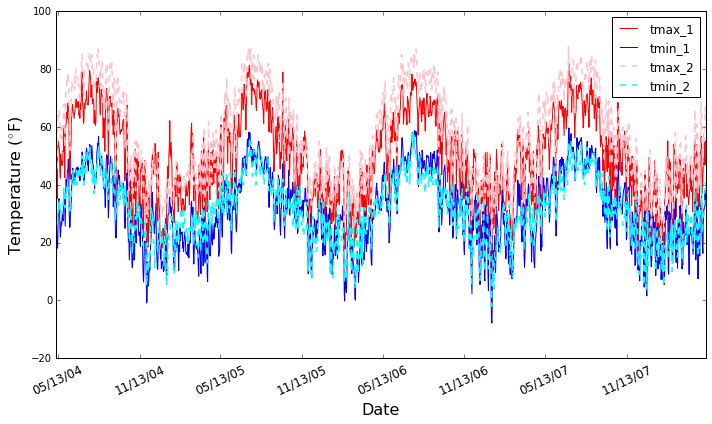

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import (
    DAILY, MONTHLY, DateFormatter, rrulewrapper, 
    RRuleLocator, drange
)
# not important: set up date formatting for plot
rule = rrulewrapper(MONTHLY, interval=6)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')

# IMPORTANT:
tmax_1 = d.variables['tmax_1']
tmax_1_lastyear = tmax_1[-365:]

tmax_1 = d.variables['tmax_1']
tmax_1_lastyear = tmax_1[-365:]

years_back = 4
days_back = years_back * 365
temp_dict = {
    k: d.variables[k][-days_back:] for k in ['tmax_1', 'tmin_1', 'tmax_2', 'tmin_2']
}

tv = t[-days_back:]
dates = num2date(tv, t.units)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))


plt.plot(dates, temp_dict['tmax_1'], lw=1, color='red', label='tmax_1')
plt.plot(dates, temp_dict['tmin_1'], lw=1, color='blue', label='tmin_1')

plt.plot(dates, temp_dict['tmax_2'], lw=1.5, ls='--', color='pink', label='tmax_2')
plt.plot(dates, temp_dict['tmin_2'], lw=1.5, ls='--', color='cyan', label='tmin_2')

ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)

labels = ax.get_xticklabels()
plt.setp(labels, rotation=25, fontsize=12)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Temperature ($^{\circ}$F)', fontsize=16)
plt.legend()

## Modify Temperature Data

Now that we have some experience extracting and plotting temperature data, let's modify it, which we'll need to do for creating climate change scenarios. Array operations in numpy make this easy. In the cell below we'll create a new netCDF that goes from water 2009 to 2013. It will be identical 